## First trial of classification PSimages with ManTraNet

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Confirm the path to dataset and current directory

In [0]:
!ls ./drive/My\ Drive/Data/dataset/*.jpg | wc -l

21232


## Download the ManTraNet repo

In [0]:
!rm -rf ManTraNet
!git clone https://github.com/ISICV/ManTraNet.git

Cloning into 'ManTraNet'...
remote: Enumerating objects: 202, done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 202
Receiving objects: 100% (202/202), 139.99 MiB | 55.93 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [0]:
pip install keras==2.2.4

This is a very important addition. Because ManTraNet assumes to use tensorflow == 1.8.0 and keras >= 2.2.0. by Shota Takeshima

In [0]:
pip install tensorflow==1.8.0

## Import Dependent Libs and Set Paths

In [0]:
import os
import numpy as np 
import cv2
import requests
import sys
import glob

from PIL import Image
from io import BytesIO
from matplotlib import pyplot

import pickle

In [0]:
manTraNet_root = './ManTraNet/'
manTraNet_srcDir = os.path.join( manTraNet_root, 'src' )
sys.path.insert( 0, manTraNet_srcDir )
manTraNet_modelDir = os.path.join( manTraNet_root, 'pretrained_weights' )

### Confirm the access to image files and plot them.

In [0]:
def read_rgb_image( image_file, reshape = True) :
    rgb = cv2.imread( image_file, 1 )[...,::-1]
    if reshape:
        rgb = cv2.resize(rgb, (128, 128), interpolation = cv2.INTER_AREA)
    return rgb

In [0]:
path_to_dataset = "./drive/My Drive/Data/dataset/"

fnames_jpgs = glob.glob(path_to_dataset + "*.jpg")
fnames_jpgs.sort()

len(fnames_jpgs)

21232

In [0]:
fnames_true_jpgs = [e for e in fnames_jpgs if 'true' in e]
fnames_true_jpgs[0]
len(fnames_true_jpgs)

10616

In [0]:
fnames_fake_jpgs = [e for e in fnames_jpgs if 'fake' in e]
fnames_fake_jpgs[0:10]
len(fnames_fake_jpgs)

10616

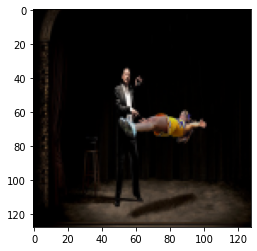

In [0]:
sample_img = read_rgb_image(fnames_fake_jpgs[0])
pyplot.imshow(sample_img)

## Play with ManTraNet to check how it performes.
### Load ManTraNet

In [0]:
import modelCore

manTraNet = modelCore.load_pretrain_model_by_index( 4, manTraNet_modelDir )

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

INFO: use activation in the last CONV=None
INFO: unfreeze feature extraction part, trainable=True


In [0]:
# ManTraNet Architecture 
print(manTraNet.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
img_in (InputLayer)                    (None, None, None, 3)      0                                                     
________________________________________________________________________________________________________________________
Featex (Model)                         (None, None, None, 256)    3675181       img_in[0][0]                            
________________________________________________________________________________________________________________________
outlierTrans (Conv2D)                  (None, None, None, 64)     16384         Featex[1][0]                            
________________________________________________________________________________________________________________________
bnorm (BatchNormalization)      

In [0]:
# Image Manipulation Classification Network
IMCFeatex = manTraNet.get_layer('Featex')
print(IMCFeatex.summary(line_length=120))

________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
image_in (InputLayer)                                 (None, None, None, 3)                           0                 
________________________________________________________________________________________________________________________
b1c1 (CombinedConv2D)                                 (None, None, None, 16)                          525               
________________________________________________________________________________________________________________________
b1c2 (Conv2DSymPadding)                               (None, None, None, 32)                          4640              
________________________________________________________________________________________________________________________
b2c1 (Conv2DSymPadding)         

In [0]:
from datetime import datetime 
def decode_an_image_array( rgb, manTraNet, dn=1 ) :
    x = np.expand_dims( rgb.astype('float32')/255.*2-1, axis=0 )[:,::dn,::dn]
    t0 = datetime.now()
    y = manTraNet.predict(x)[0,...,0]
    t1 = datetime.now()
    return y, t1-t0

def decode_an_image_file( image_file, manTraNet, dn=1 ) :
    rgb = read_rgb_image( image_file )
    mask, ptime = decode_an_image_array( rgb, manTraNet, dn )
    return rgb[::dn,::dn], mask, ptime.total_seconds()

In [0]:
fake_rgb, mask, ptime = decode_an_image_file(fnames_fake_jpgs[0], manTraNet)

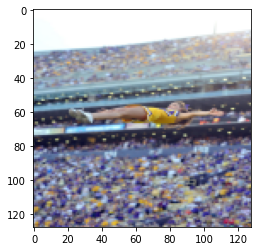

In [0]:
pyplot.imshow(read_rgb_image(fnames_true_jpgs[0]))

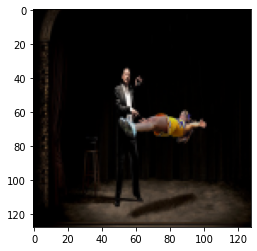

In [0]:
pyplot.imshow(fake_rgb)

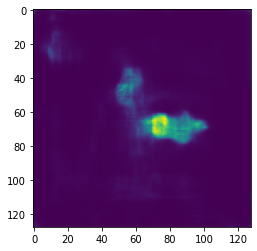

In [0]:
pyplot.imshow(mask)

In [0]:
ptime

0.743592

## Feature Extraction with ManTraNet

In [0]:
N_samples = len(fnames_jpgs)
N_start = 0

show_plots = False
X = []
y = []
filenames = []

for ind in range(N_start, N_samples):
    filename = fnames_jpgs[ind]

    try:
        rgb, mask, ptime = decode_an_image_file(filename, manTraNet)


        X.append(mask)
        if filename.endswith('_fake.jpg'):
            y.append(1)
        else:
            y.append(0)

        filenames.append(filename)

        if show_plots:
            pyplot.figure( figsize=(10,5) )
            pyplot.subplot(121)
            pyplot.imshow(rgb)
            pyplot.subplot(122)
            pyplot.imshow(mask)
            pyplot.show()

        if (ind == 0) or ((ind + 1) % 100 == 0):
            print(f"{ind + 1}, File name: {filename}")
            print(f"\tConverting time:{ptime}")

    except:

        print("\tConverting error, Skip this image")
        pass

1, File name: ./drive/My Drive/Data/dataset/10092l_fake.jpg
	Converting time:0.646543
100, File name: ./drive/My Drive/Data/dataset/10fd60_true.jpg
	Converting time:0.629648
200, File name: ./drive/My Drive/Data/dataset/10u28n_true.jpg
	Converting time:0.629484
300, File name: ./drive/My Drive/Data/dataset/11d4c8_true.jpg
	Converting time:0.578972
400, File name: ./drive/My Drive/Data/dataset/11r0kp_true.jpg
	Converting time:0.597789
500, File name: ./drive/My Drive/Data/dataset/1241ut_true.jpg
	Converting time:0.596374
	Converting error, Skip this image
600, File name: ./drive/My Drive/Data/dataset/12mpoq_true.jpg
	Converting time:0.613382
	Converting error, Skip this image
700, File name: ./drive/My Drive/Data/dataset/133d5y_true.jpg
	Converting time:0.627585
800, File name: ./drive/My Drive/Data/dataset/13ncxd_true.jpg
	Converting time:0.598399
900, File name: ./drive/My Drive/Data/dataset/1433rs_true.jpg
	Converting time:0.599252
1000, File name: ./drive/My Drive/Data/dataset/14lln

In [0]:
with open("./X.pkl", "wb") as f:
    pickle.dump(X, f)

with open("./y.pkl", "wb") as f:
    pickle.dump(y, f)

with open("./filenames.pkl", "wb") as f:
    pickle.dump(filenames, f)

## Load images converted by ManTraNet as python pickle files.
* If you tune the CNN Classifier, please start here.

21181

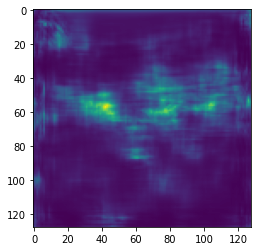

In [0]:
with open("./drive/My Drive/Data/X.pkl", "rb") as f:
    X = pickle.load(f) # read from the pickle file.
pyplot.imshow(X[1])
len(X)

In [0]:
with open("./drive/My Drive/Data/y.pkl", "rb") as f:
    y = pickle.load(f) # read from the pickle file.
len(y)

21181

In [0]:
with open("./drive/My Drive/Data/filenames.pkl", "rb") as f:
    filenames = pickle.load(f) # read from the pickle file.
len(filenames)

21181

## Prepare training and test dataset
* pairs of converted true and fake images should be included in the same dataset, training dataset or test dataset

In [0]:
# CNN
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers

import pandas as pd

Using TensorFlow backend.


* Save filenames and y as a csv file to trace later.

In [0]:
df_dataset_correct = pd.DataFrame(list(zip(filenames, y)), columns =['file_name', 'fake'])
df_dataset_correct.tail()
df_dataset_correct.to_csv("./dataset_correct_ManTraNet.csv")

* Create training, validation, and test datasets.

In [0]:
from sklearn.utils import shuffle

ratio_of_train_samples = 0.7
ratio_of_val_samples = 0.15
ratio_of_test_samples = 0.15

assert ratio_of_train_samples + ratio_of_val_samples + ratio_of_test_samples == 1

X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = to_categorical(y, 2)
print(f"X.shape:{X.shape}, y:{y.shape}")

X.shape:(21181, 128, 128, 1), y:(21181, 2)


In [0]:
st_train = 0
st_val = int(len(X) * ratio_of_train_samples)
st_test = int(len(X) * (ratio_of_train_samples + ratio_of_val_samples))
print(f"{st_train}, {st_val}, {st_test}")

X_train, y_train, fn_train = X[0:st_val], y[0:st_val], filenames[0:st_val]
X_val, y_val, fn_val = X[st_val:st_test], y[st_val:st_test], filenames[st_val:st_test]
X_test, y_test, fn_test = X[st_test:], y[st_test:], filenames[st_test:]

print(f"{X_train.shape}, {X_val.shape}, {X_test.shape}")
print(f"{y_train.shape}, {y_val.shape}, {y_test.shape}")
print(f"{len(fn_train)}, {len(fn_val)}, {len(fn_test)}")

0, 14826, 18003
(14826, 128, 128, 1), (3177, 128, 128, 1), (3178, 128, 128, 1)
(14826, 2), (3177, 2), (3178, 2)
14826, 3177, 3178


## Create a CNN Clasifier and Tune it with features extracted by ManTraNet

To recap: here the most common ways to prevent overfitting in neural networks:
https://keras.rstudio.com/articles/tutorial_overfit_underfit.html

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

In [0]:
print(tf.__version__)
tf.keras.backend.clear_session()

try:
    del model1
    del model2
except:
    print("No model in memory")

2.2.0-rc3
No model in memory


In [0]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                     activation ='relu', input_shape = (128,128,1)),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                     activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = "sigmoid")
])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [0]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3),padding = 'valid', 
                     activation ='relu', input_shape = (128,128,1)),
#    tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3),padding = 'valid', 
#                     activation ='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(6,6)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(256, activation = "relu"),
#    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation = "softmax")
])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 4)         0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1764)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               451840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5

In [0]:
# Model tools
model = model2

optimizer = tf.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = tf.keras.optimizers.Nadam()

model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["acc"])

# I test two stopping criterias:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                              min_delta=0.001,
                              patience=10,
                              verbose=0, mode='max')

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [0]:
# Training
np.random.seed(19860222)

epochs = 20
batch_size = 50

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
          validation_data = (X_val, y_val), callbacks=[callbacks])

Epoch 1/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6923 - acc: 0.5158 - val_loss: 0.6915 - val_acc: 0.5269
Epoch 2/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6918 - acc: 0.5189 - val_loss: 0.6913 - val_acc: 0.5253
Epoch 3/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6912 - acc: 0.5253 - val_loss: 0.6911 - val_acc: 0.5279
Epoch 4/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6908 - acc: 0.5260 - val_loss: 0.6906 - val_acc: 0.5417
Epoch 5/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6902 - acc: 0.5311 - val_loss: 0.6903 - val_acc: 0.5376
Epoch 6/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6893 - acc: 0.5348 - val_loss: 0.6906 - val_acc: 0.5329
Epoch 7/20
297/297 [==============================] - 7s 23ms/step - loss: 0.6886 - acc: 0.5384 - val_loss: 0.6902 - val_acc: 0.5442
Epoch 8/20
297/297 [==============================] - 7s 23ms/step - 

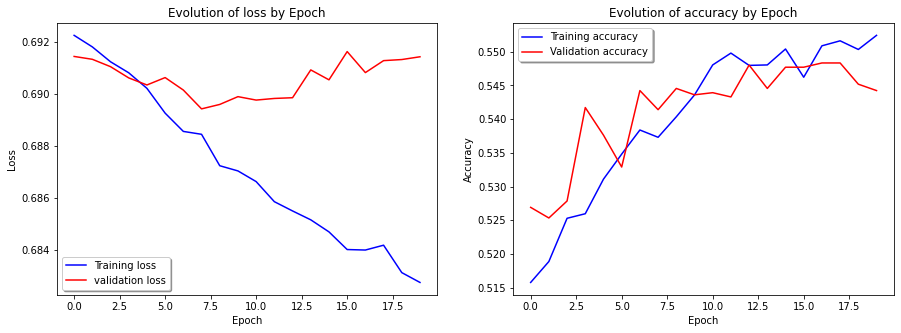

In [0]:
f# Plot the loss and accuracy curves for training and validation

fig, ax = pyplot.subplots(1,2, figsize=(15,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Evolution of loss by Epoch")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Evolution of accuracy by Epoch")
legend = ax[1].legend(loc='best', shadow=True)

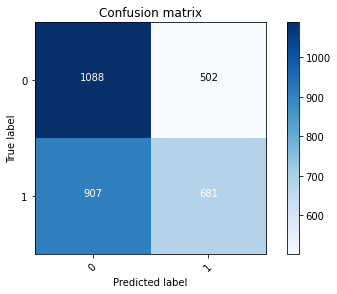

In [0]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')


# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

# ~65% accuracy

## Train and evaluate on test data

In [0]:
X_train_val = np.concatenate((X_train, X_val), axis = 0)
y_train_val = np.concatenate((y_train, y_val), axis = 0)
print(f"{X_train_val.shape} {y_train_val.shape}")

(18003, 128, 128, 1) (18003, 2)


In [0]:
model.fit(X_train_val, y_train_val, batch_size = batch_size, epochs = epochs,
          validation_data = (X_test, y_test), callbacks=[callbacks])

Epoch 1/20
361/361 [==============================] - 8s 23ms/step - loss: 0.6842 - acc: 0.5502 - val_loss: 0.6839 - val_acc: 0.5588
Epoch 2/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6822 - acc: 0.5541 - val_loss: 0.6822 - val_acc: 0.5595
Epoch 3/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6822 - acc: 0.5538 - val_loss: 0.6810 - val_acc: 0.5639
Epoch 4/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6812 - acc: 0.5544 - val_loss: 0.6800 - val_acc: 0.5677
Epoch 5/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6805 - acc: 0.5605 - val_loss: 0.6789 - val_acc: 0.5711
Epoch 6/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6806 - acc: 0.5615 - val_loss: 0.6794 - val_acc: 0.5642
Epoch 7/20
361/361 [==============================] - 8s 22ms/step - loss: 0.6802 - acc: 0.5539 - val_loss: 0.6782 - val_acc: 0.5658
Epoch 8/20
361/361 [==============================] - 9s 24ms/step - 

In [0]:
model.evaluate(X_test, y_test)

100/100 [==============================] - 1s 6ms/step - loss: 0.6756 - acc: 0.5752


[0.6755883097648621, 0.5752045512199402]

In [0]:
y_pred = model.predict(X_test)

In [0]:
y_pred

array([[0.64630306, 0.35369796],
       [0.4436689 , 0.5629525 ],
       [0.4300988 , 0.5811288 ],
       ...,
       [0.5134549 , 0.4926251 ],
       [0.50989765, 0.48897827],
       [0.53250945, 0.466018  ]], dtype=float32)

In [0]:
path = fn_test
label_0 = list(y_pred[:,0])
label_1 = list(y_pred[:,1])

df_output = pd.DataFrame(zip(path, label_0, label_1), columns =['path', 'label_0', 'label_1'])
df_output.to_csv("./output_ManTraNet_CNN.csv")